# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits! We will use the loss functions and models we built in the previous exercises.


The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
>* The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
>* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

In this notebook, we will be using the [MNIST Dataset](http://yann.lecun.com/exdb/mnist/), a dataset of handwritten digits. We can use the torch [Datasets API](https://pytorch.org/vision/stable/datasets.html) to load the whole dataset directly. The MNIST dataset is made of 28x28 grayscale images.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

We visualize a single random example of the MNIST dataset. You can rerun this cell multiple times to see different logits.

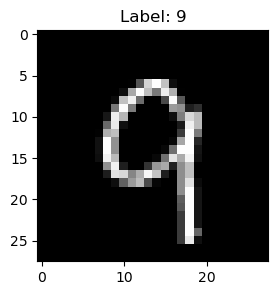

In [3]:
# obtain one batch of training images
rand_index = np.random.randint(0, len(train_data), 1)[0]
images = train_data[rand_index][0]
label = train_data[rand_index][1]
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. In this exercise, we will be using the Generator and Discriminator we previously built.

## Discriminator

In [4]:
import torch.nn as nn

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
        # define the final layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)        
        
        # define the dropout
        self.dropout = nn.Dropout(0.3)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten image
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # we are using BCE with logits loss so the last activation is not required
        x = self.fc4(x)
        return x

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()
        # define hidden linear layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # define the activation
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)

        x = self.fc2(x)
        x = self.activation(x)

        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        x = self.final_activation(x)
        return x

## Model hyperparameters

In [7]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of FIRST hidden layer in the discriminator
d_hidden_size = 128

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [8]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (final_activation): Tanh()
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. For this exercise, we will use the loss functions we previously implemented. 

In [9]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [10]:
import torch.optim as optim

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [11]:
from datetime import datetime
import pickle as pkl

In [12]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

In [13]:
import torch.distributions.uniform as u

def get_random_latent_batch(batch_size, z_size):
    return u.Uniform(-1, 1).sample((batch_size, z_size))

2023-07-14 15:02:03 | Epoch [1/50] | Batch 0/469 | d_loss: 1.4059 | g_loss: 0.6688
2023-07-14 15:02:06 | Epoch [1/50] | Batch 100/469 | d_loss: 1.0512 | g_loss: 0.8012
2023-07-14 15:02:09 | Epoch [1/50] | Batch 200/469 | d_loss: 0.6268 | g_loss: 1.5673
2023-07-14 15:02:11 | Epoch [1/50] | Batch 300/469 | d_loss: 0.6945 | g_loss: 1.4763
2023-07-14 15:02:14 | Epoch [1/50] | Batch 400/469 | d_loss: 0.4855 | g_loss: 2.3418


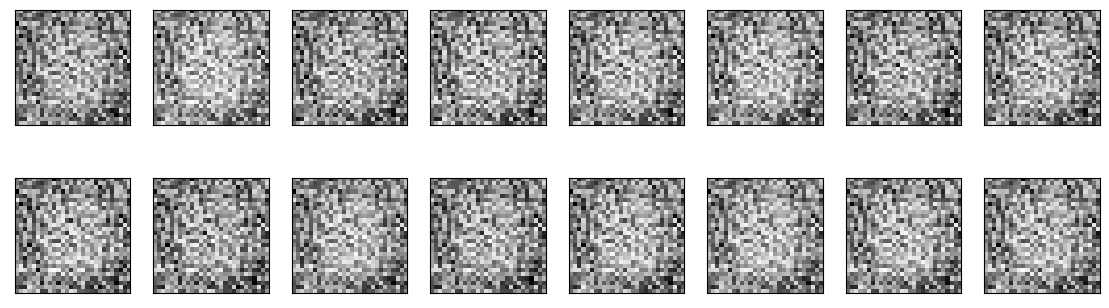

2023-07-14 15:02:22 | Epoch [2/50] | Batch 0/469 | d_loss: 0.4568 | g_loss: 2.6829
2023-07-14 15:02:25 | Epoch [2/50] | Batch 100/469 | d_loss: 0.3929 | g_loss: 3.5892
2023-07-14 15:02:27 | Epoch [2/50] | Batch 200/469 | d_loss: 0.3880 | g_loss: 4.5044
2023-07-14 15:02:30 | Epoch [2/50] | Batch 300/469 | d_loss: 0.3934 | g_loss: 5.1618
2023-07-14 15:02:32 | Epoch [2/50] | Batch 400/469 | d_loss: 0.3800 | g_loss: 4.8257


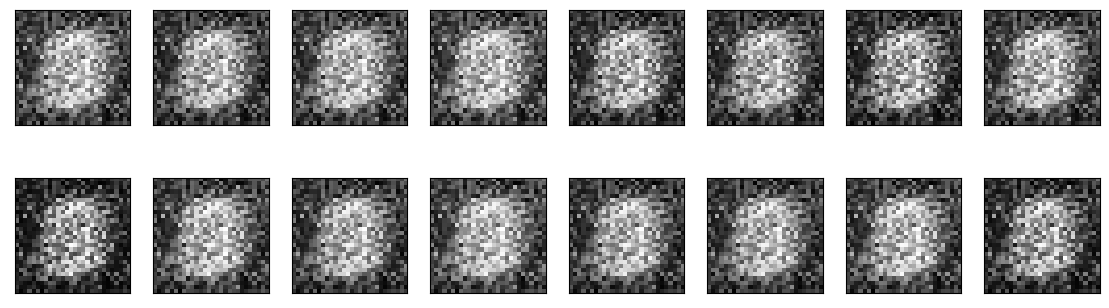

2023-07-14 15:02:41 | Epoch [3/50] | Batch 0/469 | d_loss: 0.4855 | g_loss: 3.6888
2023-07-14 15:02:43 | Epoch [3/50] | Batch 100/469 | d_loss: 0.5538 | g_loss: 4.5448
2023-07-14 15:02:46 | Epoch [3/50] | Batch 200/469 | d_loss: 0.5091 | g_loss: 5.2322
2023-07-14 15:02:48 | Epoch [3/50] | Batch 300/469 | d_loss: 0.4154 | g_loss: 4.6082
2023-07-14 15:02:51 | Epoch [3/50] | Batch 400/469 | d_loss: 0.6380 | g_loss: 2.5783


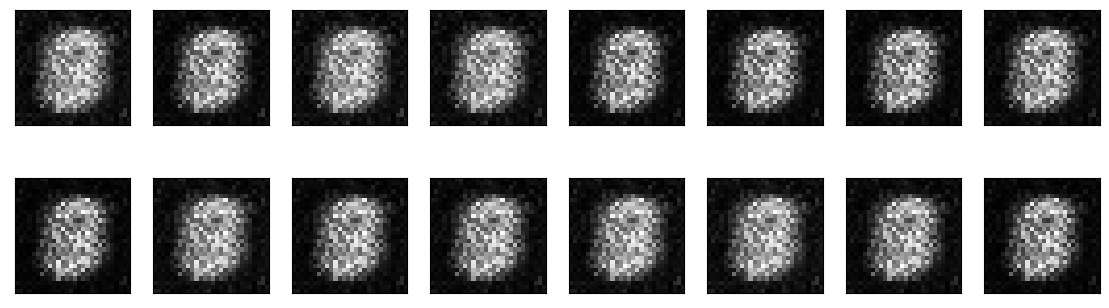

2023-07-14 15:02:59 | Epoch [4/50] | Batch 0/469 | d_loss: 0.7317 | g_loss: 2.1549
2023-07-14 15:03:02 | Epoch [4/50] | Batch 100/469 | d_loss: 0.7420 | g_loss: 3.2731
2023-07-14 15:03:04 | Epoch [4/50] | Batch 200/469 | d_loss: 0.5261 | g_loss: 3.8039
2023-07-14 15:03:07 | Epoch [4/50] | Batch 300/469 | d_loss: 0.5045 | g_loss: 3.4850
2023-07-14 15:03:09 | Epoch [4/50] | Batch 400/469 | d_loss: 0.5193 | g_loss: 3.3138


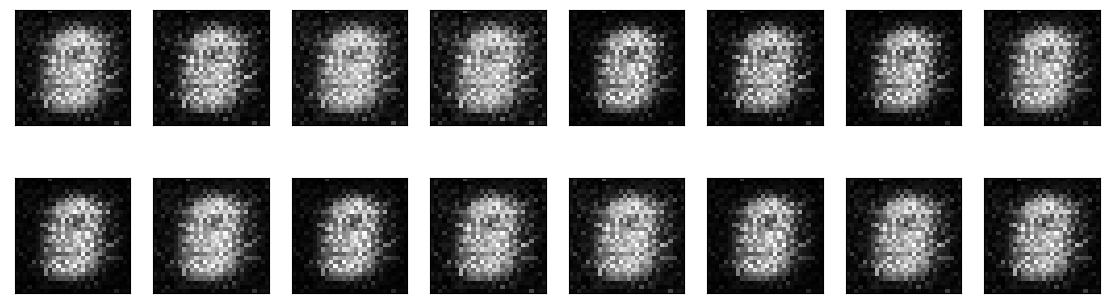

2023-07-14 15:03:18 | Epoch [5/50] | Batch 0/469 | d_loss: 0.5853 | g_loss: 3.3763
2023-07-14 15:03:21 | Epoch [5/50] | Batch 100/469 | d_loss: 0.5679 | g_loss: 3.9038
2023-07-14 15:03:24 | Epoch [5/50] | Batch 200/469 | d_loss: 0.5088 | g_loss: 5.0410
2023-07-14 15:03:26 | Epoch [5/50] | Batch 300/469 | d_loss: 0.4431 | g_loss: 5.0987
2023-07-14 15:03:29 | Epoch [5/50] | Batch 400/469 | d_loss: 0.5153 | g_loss: 5.0750


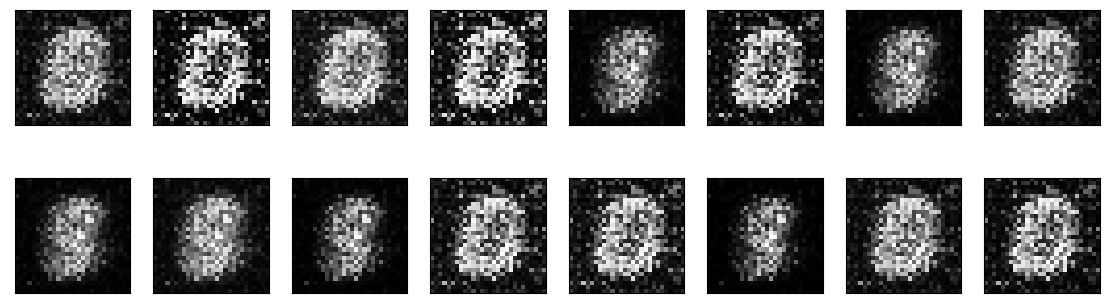

2023-07-14 15:03:38 | Epoch [6/50] | Batch 0/469 | d_loss: 0.6646 | g_loss: 5.4312
2023-07-14 15:03:41 | Epoch [6/50] | Batch 100/469 | d_loss: 0.6466 | g_loss: 3.2264
2023-07-14 15:03:43 | Epoch [6/50] | Batch 200/469 | d_loss: 0.5446 | g_loss: 4.0342
2023-07-14 15:03:46 | Epoch [6/50] | Batch 300/469 | d_loss: 0.4890 | g_loss: 5.3186
2023-07-14 15:03:49 | Epoch [6/50] | Batch 400/469 | d_loss: 0.4033 | g_loss: 5.5272


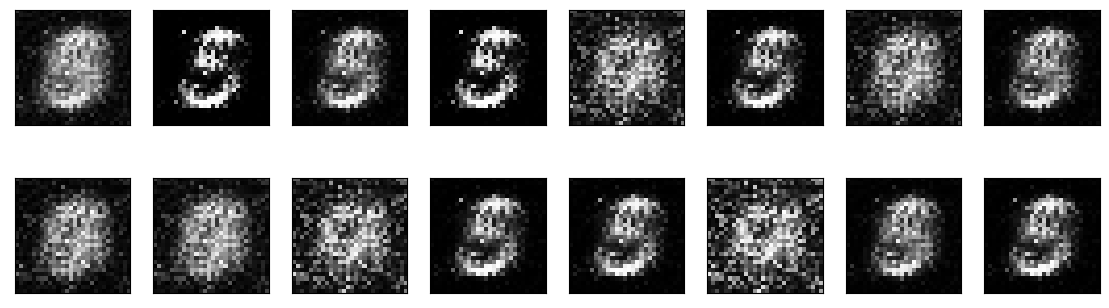

2023-07-14 15:03:59 | Epoch [7/50] | Batch 0/469 | d_loss: 0.4656 | g_loss: 5.0472
2023-07-14 15:04:02 | Epoch [7/50] | Batch 100/469 | d_loss: 0.4557 | g_loss: 4.5122
2023-07-14 15:04:05 | Epoch [7/50] | Batch 200/469 | d_loss: 0.4714 | g_loss: 4.3825
2023-07-14 15:04:08 | Epoch [7/50] | Batch 300/469 | d_loss: 0.4703 | g_loss: 4.4649
2023-07-14 15:04:11 | Epoch [7/50] | Batch 400/469 | d_loss: 0.4947 | g_loss: 4.4418


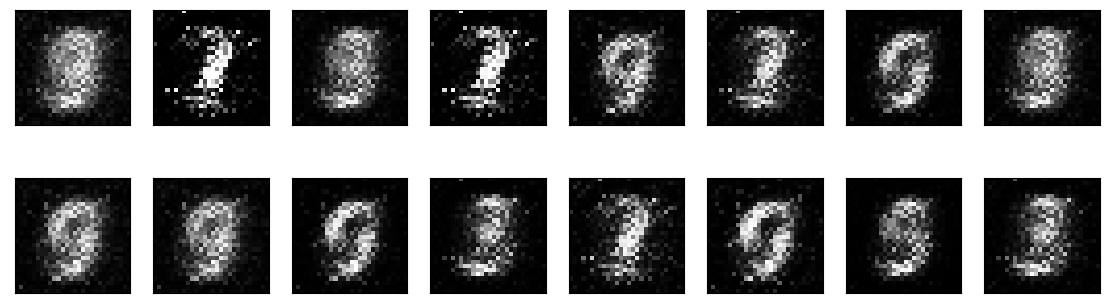

2023-07-14 15:04:20 | Epoch [8/50] | Batch 0/469 | d_loss: 0.4572 | g_loss: 3.9360
2023-07-14 15:04:23 | Epoch [8/50] | Batch 100/469 | d_loss: 0.4838 | g_loss: 5.2641
2023-07-14 15:04:26 | Epoch [8/50] | Batch 200/469 | d_loss: 0.6146 | g_loss: 5.1429
2023-07-14 15:04:28 | Epoch [8/50] | Batch 300/469 | d_loss: 0.5528 | g_loss: 5.2442
2023-07-14 15:04:31 | Epoch [8/50] | Batch 400/469 | d_loss: 0.4374 | g_loss: 6.0226


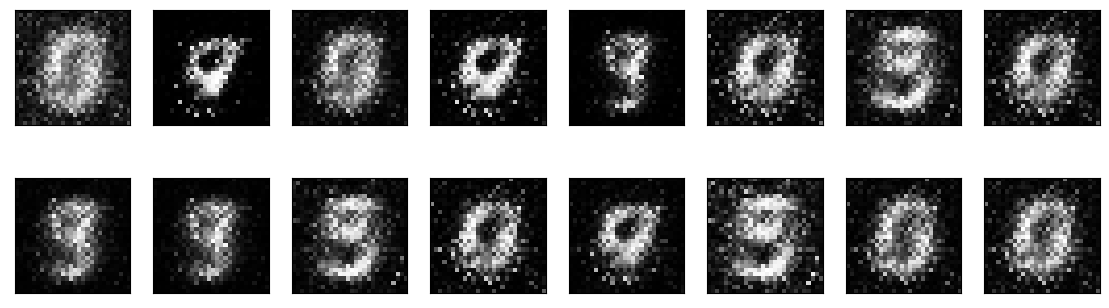

2023-07-14 15:04:40 | Epoch [9/50] | Batch 0/469 | d_loss: 0.5885 | g_loss: 3.9489
2023-07-14 15:04:42 | Epoch [9/50] | Batch 100/469 | d_loss: 0.6133 | g_loss: 3.2777
2023-07-14 15:04:45 | Epoch [9/50] | Batch 200/469 | d_loss: 0.5090 | g_loss: 4.5431
2023-07-14 15:04:48 | Epoch [9/50] | Batch 300/469 | d_loss: 0.5644 | g_loss: 3.0567
2023-07-14 15:04:50 | Epoch [9/50] | Batch 400/469 | d_loss: 0.6576 | g_loss: 3.1974


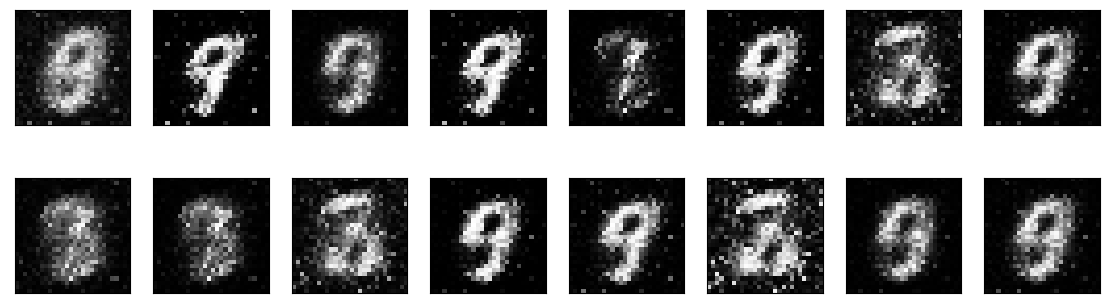

2023-07-14 15:05:00 | Epoch [10/50] | Batch 0/469 | d_loss: 0.5766 | g_loss: 3.7760
2023-07-14 15:05:03 | Epoch [10/50] | Batch 100/469 | d_loss: 0.5050 | g_loss: 3.6047
2023-07-14 15:05:06 | Epoch [10/50] | Batch 200/469 | d_loss: 0.5039 | g_loss: 4.2004
2023-07-14 15:05:09 | Epoch [10/50] | Batch 300/469 | d_loss: 0.6525 | g_loss: 3.4069
2023-07-14 15:05:12 | Epoch [10/50] | Batch 400/469 | d_loss: 0.7530 | g_loss: 3.4942


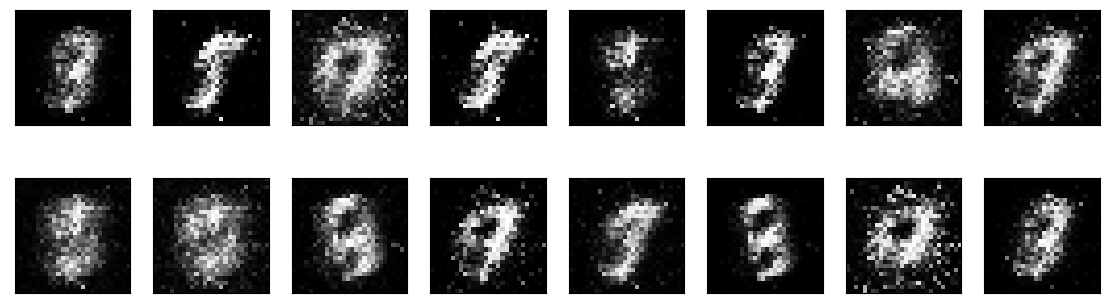

2023-07-14 15:05:22 | Epoch [11/50] | Batch 0/469 | d_loss: 0.5468 | g_loss: 3.6664
2023-07-14 15:05:25 | Epoch [11/50] | Batch 100/469 | d_loss: 0.5971 | g_loss: 2.9322
2023-07-14 15:05:27 | Epoch [11/50] | Batch 200/469 | d_loss: 0.5658 | g_loss: 5.0115
2023-07-14 15:05:30 | Epoch [11/50] | Batch 300/469 | d_loss: 0.5194 | g_loss: 3.9545
2023-07-14 15:05:32 | Epoch [11/50] | Batch 400/469 | d_loss: 0.6504 | g_loss: 2.8258


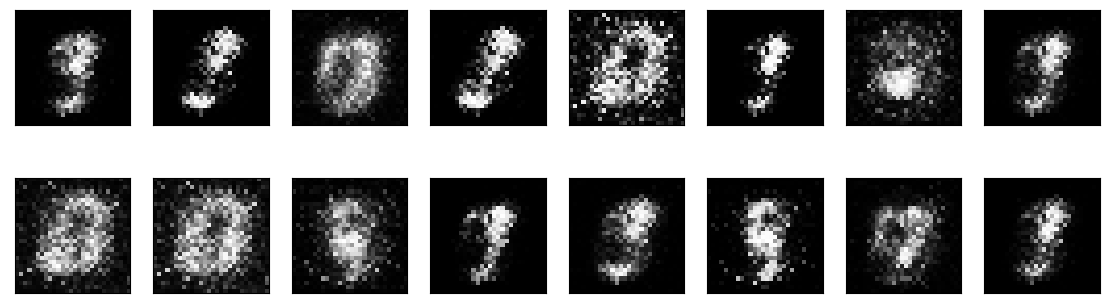

2023-07-14 15:05:42 | Epoch [12/50] | Batch 0/469 | d_loss: 0.5315 | g_loss: 3.7320
2023-07-14 15:05:45 | Epoch [12/50] | Batch 100/469 | d_loss: 0.6057 | g_loss: 3.5004
2023-07-14 15:05:48 | Epoch [12/50] | Batch 200/469 | d_loss: 0.5850 | g_loss: 3.8887
2023-07-14 15:05:51 | Epoch [12/50] | Batch 300/469 | d_loss: 0.6198 | g_loss: 3.6485
2023-07-14 15:05:54 | Epoch [12/50] | Batch 400/469 | d_loss: 0.6270 | g_loss: 3.7946


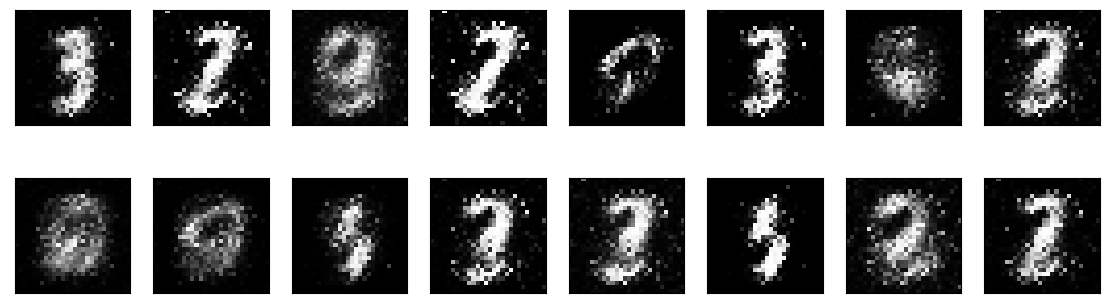

2023-07-14 15:06:04 | Epoch [13/50] | Batch 0/469 | d_loss: 0.6258 | g_loss: 3.4304
2023-07-14 15:06:06 | Epoch [13/50] | Batch 100/469 | d_loss: 0.6411 | g_loss: 3.7499
2023-07-14 15:06:09 | Epoch [13/50] | Batch 200/469 | d_loss: 0.6396 | g_loss: 4.0113
2023-07-14 15:06:12 | Epoch [13/50] | Batch 300/469 | d_loss: 0.6871 | g_loss: 2.8656
2023-07-14 15:06:15 | Epoch [13/50] | Batch 400/469 | d_loss: 0.6797 | g_loss: 3.0946


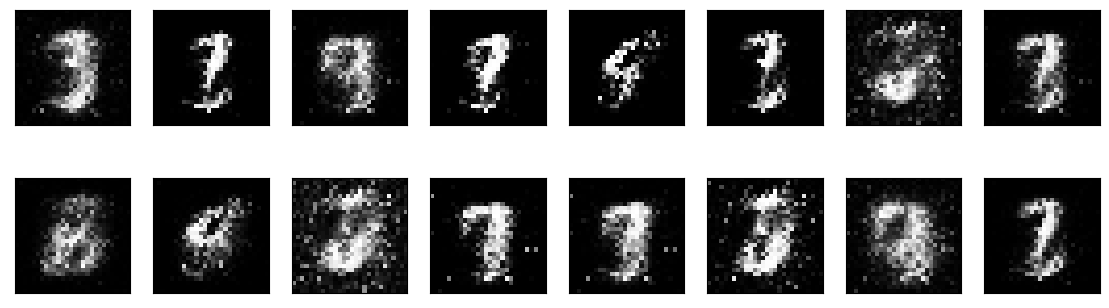

2023-07-14 15:06:25 | Epoch [14/50] | Batch 0/469 | d_loss: 0.5438 | g_loss: 3.8075
2023-07-14 15:06:28 | Epoch [14/50] | Batch 100/469 | d_loss: 0.6262 | g_loss: 3.0565
2023-07-14 15:06:31 | Epoch [14/50] | Batch 200/469 | d_loss: 0.6005 | g_loss: 3.2940
2023-07-14 15:06:34 | Epoch [14/50] | Batch 300/469 | d_loss: 0.5992 | g_loss: 3.4095
2023-07-14 15:06:37 | Epoch [14/50] | Batch 400/469 | d_loss: 0.5369 | g_loss: 3.6127


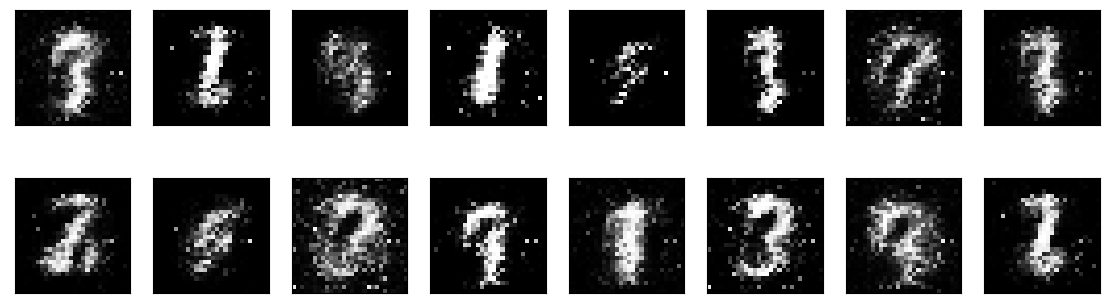

2023-07-14 15:06:47 | Epoch [15/50] | Batch 0/469 | d_loss: 0.6783 | g_loss: 3.1447
2023-07-14 15:06:50 | Epoch [15/50] | Batch 100/469 | d_loss: 0.7505 | g_loss: 3.4604
2023-07-14 15:06:53 | Epoch [15/50] | Batch 200/469 | d_loss: 0.6765 | g_loss: 4.2669
2023-07-14 15:06:55 | Epoch [15/50] | Batch 300/469 | d_loss: 0.8247 | g_loss: 3.1457
2023-07-14 15:06:58 | Epoch [15/50] | Batch 400/469 | d_loss: 0.5946 | g_loss: 3.0329


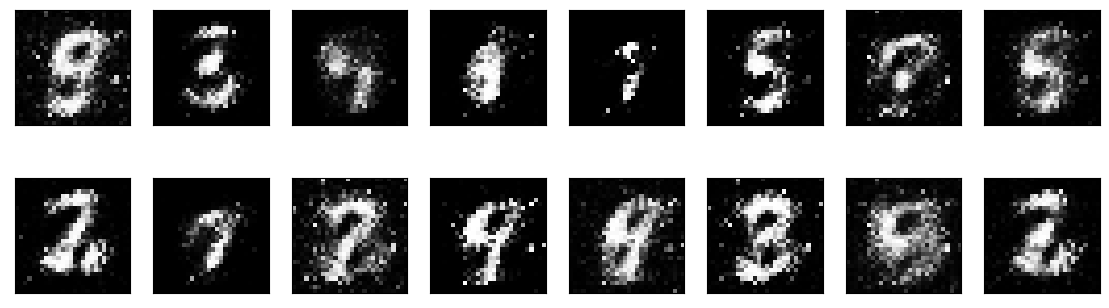

2023-07-14 15:07:08 | Epoch [16/50] | Batch 0/469 | d_loss: 0.8050 | g_loss: 3.4924
2023-07-14 15:07:11 | Epoch [16/50] | Batch 100/469 | d_loss: 0.6791 | g_loss: 2.6616
2023-07-14 15:07:14 | Epoch [16/50] | Batch 200/469 | d_loss: 0.6522 | g_loss: 3.4560
2023-07-14 15:07:17 | Epoch [16/50] | Batch 300/469 | d_loss: 0.5833 | g_loss: 3.1845
2023-07-14 15:07:20 | Epoch [16/50] | Batch 400/469 | d_loss: 0.6923 | g_loss: 3.1765


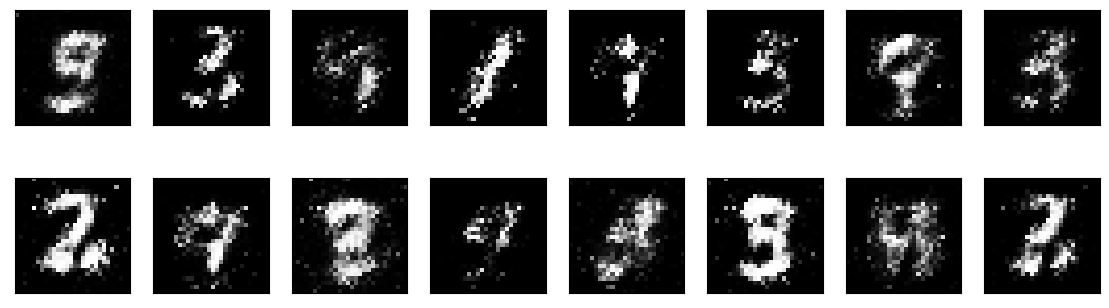

2023-07-14 15:07:29 | Epoch [17/50] | Batch 0/469 | d_loss: 0.6741 | g_loss: 2.8723
2023-07-14 15:07:32 | Epoch [17/50] | Batch 100/469 | d_loss: 0.8779 | g_loss: 2.9716
2023-07-14 15:07:34 | Epoch [17/50] | Batch 200/469 | d_loss: 0.6423 | g_loss: 2.8101
2023-07-14 15:07:37 | Epoch [17/50] | Batch 300/469 | d_loss: 0.7547 | g_loss: 3.2570
2023-07-14 15:07:39 | Epoch [17/50] | Batch 400/469 | d_loss: 0.6242 | g_loss: 3.3968


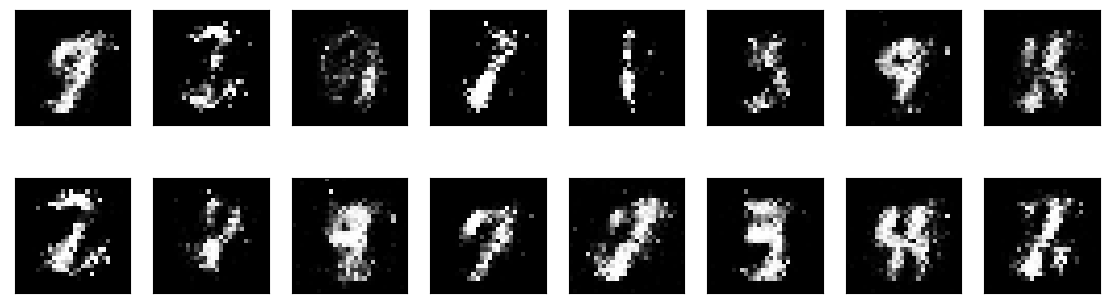

2023-07-14 15:07:48 | Epoch [18/50] | Batch 0/469 | d_loss: 0.8484 | g_loss: 3.3360
2023-07-14 15:07:51 | Epoch [18/50] | Batch 100/469 | d_loss: 0.7411 | g_loss: 3.5148
2023-07-14 15:07:54 | Epoch [18/50] | Batch 200/469 | d_loss: 0.6312 | g_loss: 2.6954
2023-07-14 15:07:57 | Epoch [18/50] | Batch 300/469 | d_loss: 0.8019 | g_loss: 2.9514
2023-07-14 15:07:59 | Epoch [18/50] | Batch 400/469 | d_loss: 0.6052 | g_loss: 3.2508


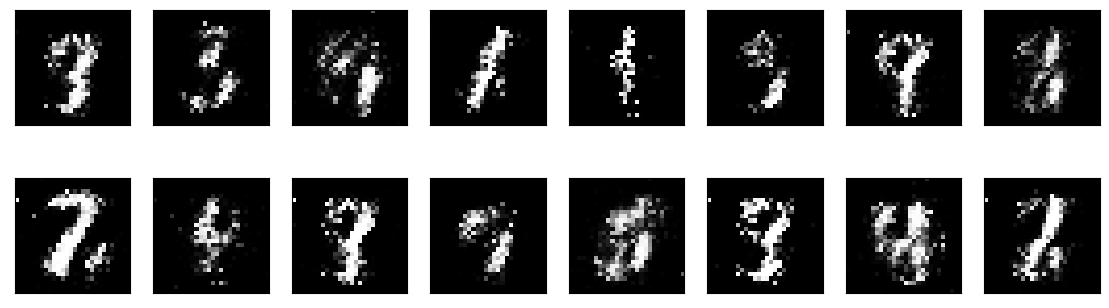

2023-07-14 15:08:09 | Epoch [19/50] | Batch 0/469 | d_loss: 0.7127 | g_loss: 3.9768
2023-07-14 15:08:12 | Epoch [19/50] | Batch 100/469 | d_loss: 0.6802 | g_loss: 3.4865
2023-07-14 15:08:14 | Epoch [19/50] | Batch 200/469 | d_loss: 0.7162 | g_loss: 3.3903
2023-07-14 15:08:17 | Epoch [19/50] | Batch 300/469 | d_loss: 0.6789 | g_loss: 3.4007
2023-07-14 15:08:20 | Epoch [19/50] | Batch 400/469 | d_loss: 0.6808 | g_loss: 3.1665


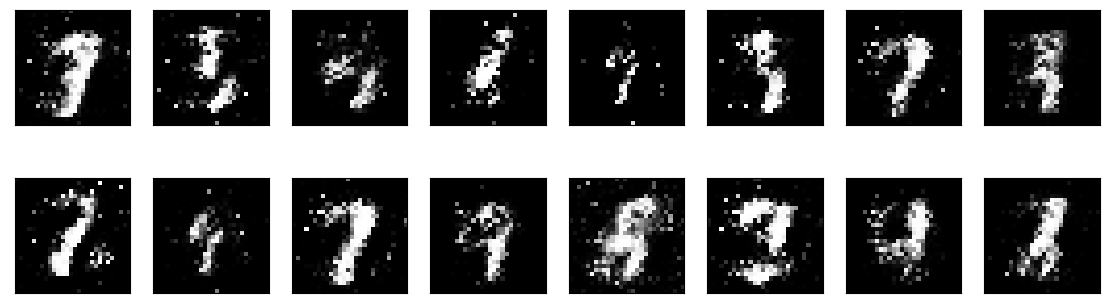

2023-07-14 15:08:30 | Epoch [20/50] | Batch 0/469 | d_loss: 0.7884 | g_loss: 2.6453
2023-07-14 15:08:32 | Epoch [20/50] | Batch 100/469 | d_loss: 0.7964 | g_loss: 3.3590
2023-07-14 15:08:35 | Epoch [20/50] | Batch 200/469 | d_loss: 0.5938 | g_loss: 3.1025
2023-07-14 15:08:38 | Epoch [20/50] | Batch 300/469 | d_loss: 0.6499 | g_loss: 2.8853
2023-07-14 15:08:40 | Epoch [20/50] | Batch 400/469 | d_loss: 0.7213 | g_loss: 3.1250


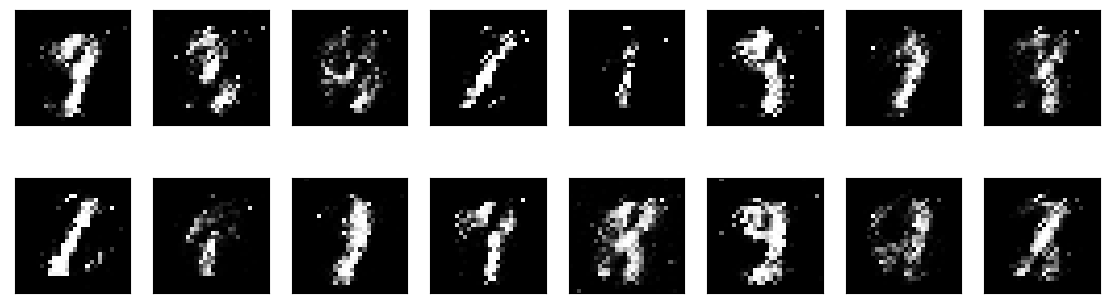

2023-07-14 15:08:49 | Epoch [21/50] | Batch 0/469 | d_loss: 0.7448 | g_loss: 3.3209
2023-07-14 15:08:52 | Epoch [21/50] | Batch 100/469 | d_loss: 0.7450 | g_loss: 2.5933
2023-07-14 15:08:54 | Epoch [21/50] | Batch 200/469 | d_loss: 0.6475 | g_loss: 3.7890
2023-07-14 15:08:57 | Epoch [21/50] | Batch 300/469 | d_loss: 0.6224 | g_loss: 2.9556
2023-07-14 15:08:59 | Epoch [21/50] | Batch 400/469 | d_loss: 0.7097 | g_loss: 3.1734


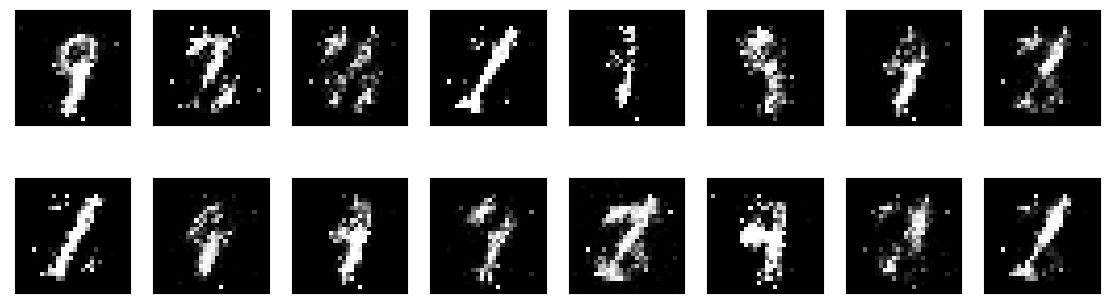

2023-07-14 15:09:09 | Epoch [22/50] | Batch 0/469 | d_loss: 0.7452 | g_loss: 3.0211
2023-07-14 15:09:12 | Epoch [22/50] | Batch 100/469 | d_loss: 0.7197 | g_loss: 3.1397
2023-07-14 15:09:15 | Epoch [22/50] | Batch 200/469 | d_loss: 0.6513 | g_loss: 3.7603
2023-07-14 15:09:17 | Epoch [22/50] | Batch 300/469 | d_loss: 0.6331 | g_loss: 3.4758
2023-07-14 15:09:20 | Epoch [22/50] | Batch 400/469 | d_loss: 0.7674 | g_loss: 3.0590


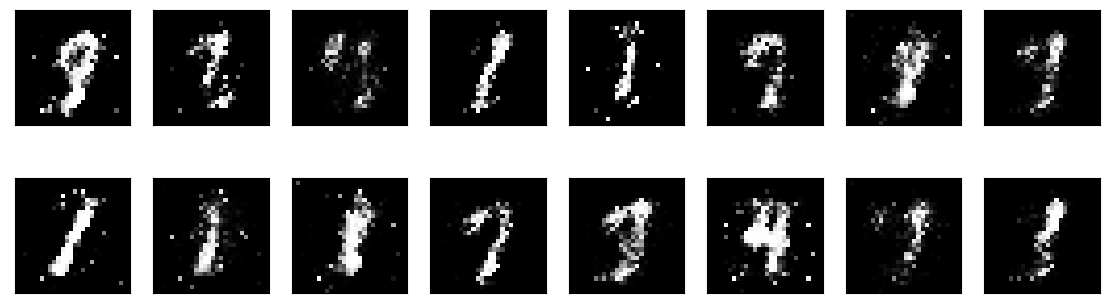

2023-07-14 15:09:29 | Epoch [23/50] | Batch 0/469 | d_loss: 0.6199 | g_loss: 2.8326
2023-07-14 15:09:32 | Epoch [23/50] | Batch 100/469 | d_loss: 0.6629 | g_loss: 3.2723
2023-07-14 15:09:34 | Epoch [23/50] | Batch 200/469 | d_loss: 0.6868 | g_loss: 3.2169
2023-07-14 15:09:37 | Epoch [23/50] | Batch 300/469 | d_loss: 0.6443 | g_loss: 3.0313
2023-07-14 15:09:39 | Epoch [23/50] | Batch 400/469 | d_loss: 0.7158 | g_loss: 3.1378


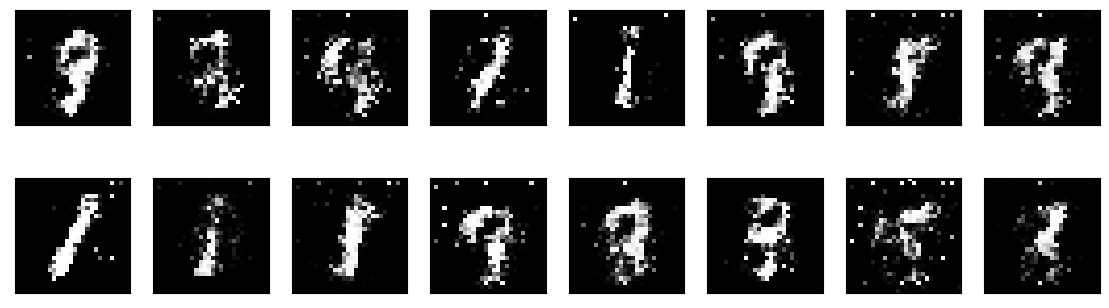

2023-07-14 15:09:49 | Epoch [24/50] | Batch 0/469 | d_loss: 0.6716 | g_loss: 3.6245
2023-07-14 15:09:52 | Epoch [24/50] | Batch 100/469 | d_loss: 0.7452 | g_loss: 3.0240
2023-07-14 15:09:55 | Epoch [24/50] | Batch 200/469 | d_loss: 0.6117 | g_loss: 3.8804
2023-07-14 15:09:58 | Epoch [24/50] | Batch 300/469 | d_loss: 0.6384 | g_loss: 3.7294
2023-07-14 15:10:01 | Epoch [24/50] | Batch 400/469 | d_loss: 0.6889 | g_loss: 3.5973


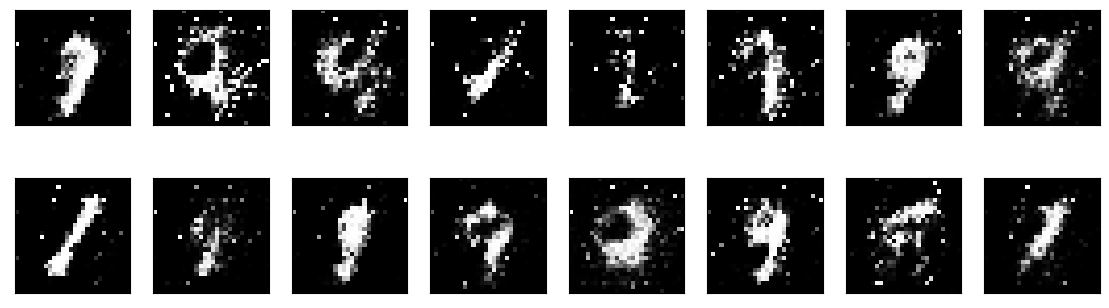

2023-07-14 15:10:09 | Epoch [25/50] | Batch 0/469 | d_loss: 0.5933 | g_loss: 3.1854
2023-07-14 15:10:12 | Epoch [25/50] | Batch 100/469 | d_loss: 0.7159 | g_loss: 3.1122
2023-07-14 15:10:14 | Epoch [25/50] | Batch 200/469 | d_loss: 0.5922 | g_loss: 4.4182
2023-07-14 15:10:17 | Epoch [25/50] | Batch 300/469 | d_loss: 0.7289 | g_loss: 3.9575
2023-07-14 15:10:19 | Epoch [25/50] | Batch 400/469 | d_loss: 0.7134 | g_loss: 2.8528


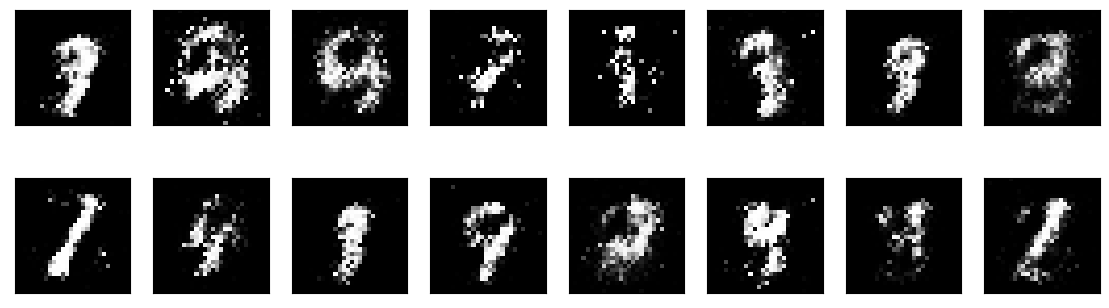

2023-07-14 15:10:28 | Epoch [26/50] | Batch 0/469 | d_loss: 0.7293 | g_loss: 3.5502
2023-07-14 15:10:31 | Epoch [26/50] | Batch 100/469 | d_loss: 0.8367 | g_loss: 3.1996
2023-07-14 15:10:34 | Epoch [26/50] | Batch 200/469 | d_loss: 0.6483 | g_loss: 3.2736
2023-07-14 15:10:37 | Epoch [26/50] | Batch 300/469 | d_loss: 0.6489 | g_loss: 2.8097
2023-07-14 15:10:40 | Epoch [26/50] | Batch 400/469 | d_loss: 0.7064 | g_loss: 3.0943


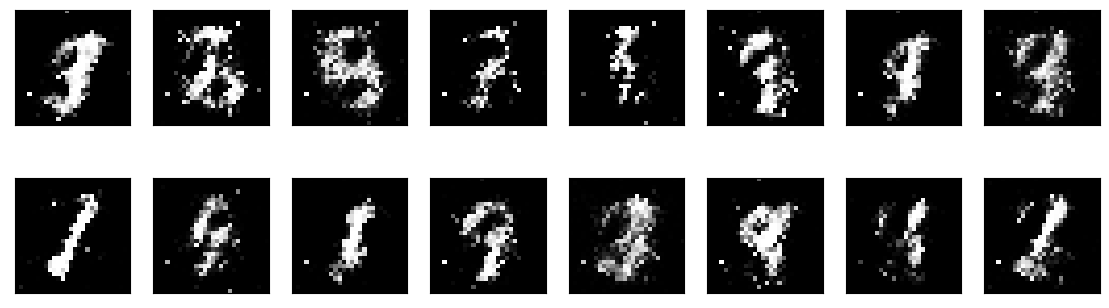

2023-07-14 15:10:49 | Epoch [27/50] | Batch 0/469 | d_loss: 0.7844 | g_loss: 2.7630
2023-07-14 15:10:52 | Epoch [27/50] | Batch 100/469 | d_loss: 0.6810 | g_loss: 2.8994
2023-07-14 15:10:55 | Epoch [27/50] | Batch 200/469 | d_loss: 0.6884 | g_loss: 3.8032
2023-07-14 15:10:59 | Epoch [27/50] | Batch 300/469 | d_loss: 0.7906 | g_loss: 2.4717
2023-07-14 15:11:01 | Epoch [27/50] | Batch 400/469 | d_loss: 0.7282 | g_loss: 3.4002


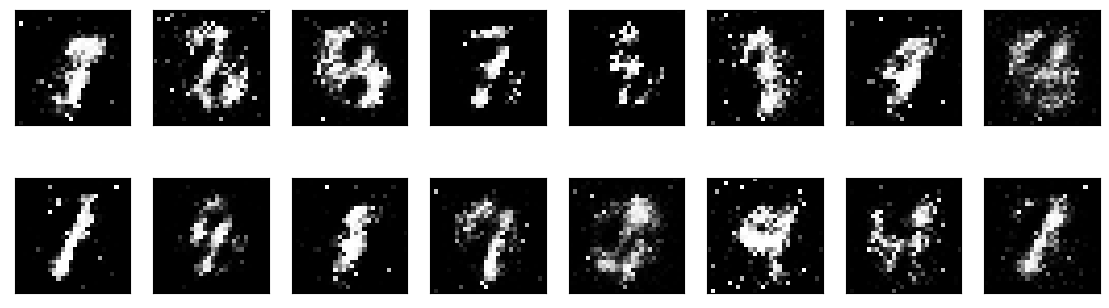

2023-07-14 15:11:11 | Epoch [28/50] | Batch 0/469 | d_loss: 0.6729 | g_loss: 3.0106
2023-07-14 15:11:14 | Epoch [28/50] | Batch 100/469 | d_loss: 0.6174 | g_loss: 3.0967
2023-07-14 15:11:16 | Epoch [28/50] | Batch 200/469 | d_loss: 0.6852 | g_loss: 4.3258
2023-07-14 15:11:19 | Epoch [28/50] | Batch 300/469 | d_loss: 0.6564 | g_loss: 3.0585
2023-07-14 15:11:22 | Epoch [28/50] | Batch 400/469 | d_loss: 0.6762 | g_loss: 3.5972


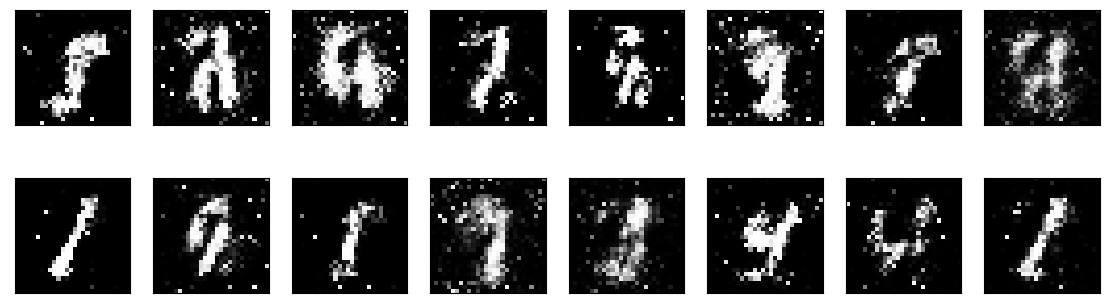

2023-07-14 15:11:31 | Epoch [29/50] | Batch 0/469 | d_loss: 0.7081 | g_loss: 2.8013
2023-07-14 15:11:34 | Epoch [29/50] | Batch 100/469 | d_loss: 0.7416 | g_loss: 2.4159
2023-07-14 15:11:37 | Epoch [29/50] | Batch 200/469 | d_loss: 0.6574 | g_loss: 4.1545
2023-07-14 15:11:44 | Epoch [29/50] | Batch 300/469 | d_loss: 0.6540 | g_loss: 2.7634
2023-07-14 15:11:50 | Epoch [29/50] | Batch 400/469 | d_loss: 0.6263 | g_loss: 3.6252


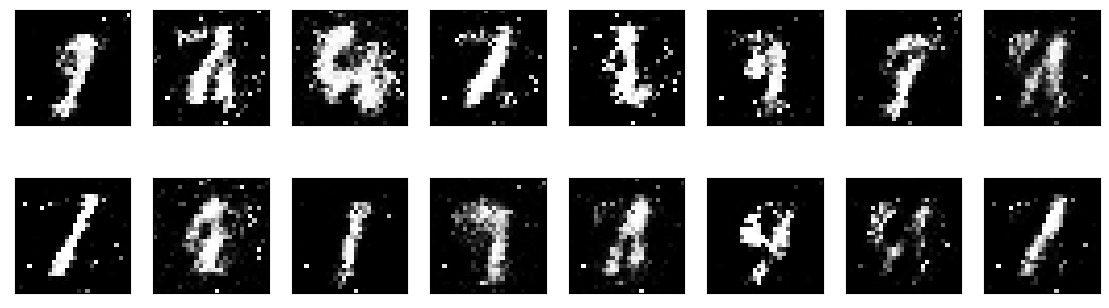

2023-07-14 15:12:04 | Epoch [30/50] | Batch 0/469 | d_loss: 0.6573 | g_loss: 3.5468
2023-07-14 15:12:07 | Epoch [30/50] | Batch 100/469 | d_loss: 0.7711 | g_loss: 2.8439
2023-07-14 15:12:09 | Epoch [30/50] | Batch 200/469 | d_loss: 0.7161 | g_loss: 3.4372
2023-07-14 15:12:12 | Epoch [30/50] | Batch 300/469 | d_loss: 0.7702 | g_loss: 2.2747
2023-07-14 15:12:15 | Epoch [30/50] | Batch 400/469 | d_loss: 0.7285 | g_loss: 2.6409


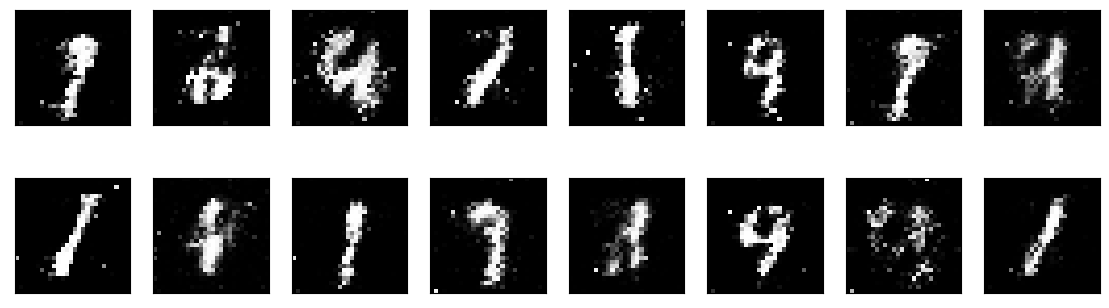

2023-07-14 15:12:25 | Epoch [31/50] | Batch 0/469 | d_loss: 0.8658 | g_loss: 2.6241
2023-07-14 15:12:28 | Epoch [31/50] | Batch 100/469 | d_loss: 0.6929 | g_loss: 2.4757
2023-07-14 15:12:30 | Epoch [31/50] | Batch 200/469 | d_loss: 0.6687 | g_loss: 3.6661
2023-07-14 15:12:33 | Epoch [31/50] | Batch 300/469 | d_loss: 0.7407 | g_loss: 2.9208
2023-07-14 15:12:36 | Epoch [31/50] | Batch 400/469 | d_loss: 0.5861 | g_loss: 3.3133


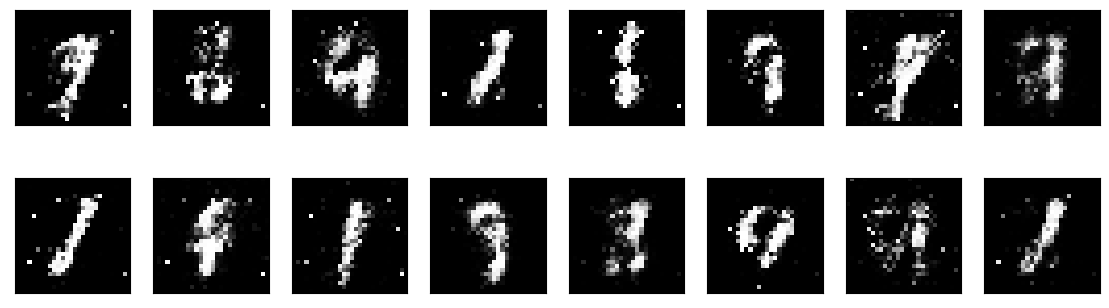

2023-07-14 15:12:44 | Epoch [32/50] | Batch 0/469 | d_loss: 0.7650 | g_loss: 2.9619
2023-07-14 15:12:47 | Epoch [32/50] | Batch 100/469 | d_loss: 0.7577 | g_loss: 2.7650
2023-07-14 15:12:49 | Epoch [32/50] | Batch 200/469 | d_loss: 0.7007 | g_loss: 2.8477
2023-07-14 15:12:52 | Epoch [32/50] | Batch 300/469 | d_loss: 0.7529 | g_loss: 2.4677
2023-07-14 15:12:55 | Epoch [32/50] | Batch 400/469 | d_loss: 0.8177 | g_loss: 2.4092


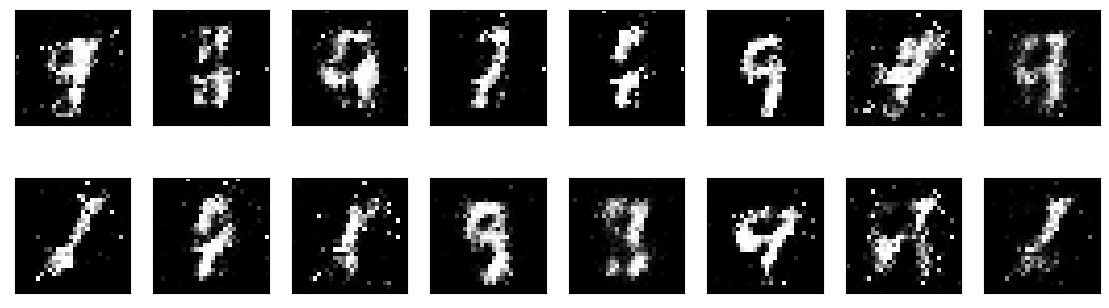

2023-07-14 15:13:06 | Epoch [33/50] | Batch 0/469 | d_loss: 0.7161 | g_loss: 2.9094
2023-07-14 15:13:09 | Epoch [33/50] | Batch 100/469 | d_loss: 0.8592 | g_loss: 2.7945
2023-07-14 15:13:11 | Epoch [33/50] | Batch 200/469 | d_loss: 0.6063 | g_loss: 3.0219
2023-07-14 15:13:14 | Epoch [33/50] | Batch 300/469 | d_loss: 0.8516 | g_loss: 2.4796
2023-07-14 15:13:17 | Epoch [33/50] | Batch 400/469 | d_loss: 0.7696 | g_loss: 3.2298


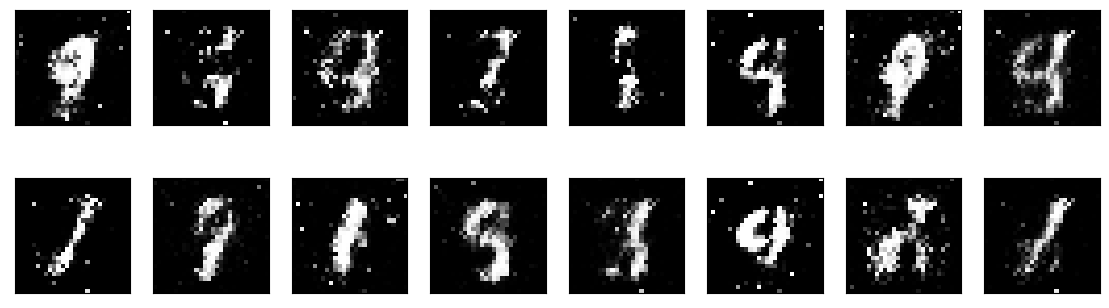

2023-07-14 15:13:27 | Epoch [34/50] | Batch 0/469 | d_loss: 0.8261 | g_loss: 2.7443
2023-07-14 15:13:29 | Epoch [34/50] | Batch 100/469 | d_loss: 0.9648 | g_loss: 3.0579
2023-07-14 15:13:32 | Epoch [34/50] | Batch 200/469 | d_loss: 0.7486 | g_loss: 2.5248
2023-07-14 15:13:34 | Epoch [34/50] | Batch 300/469 | d_loss: 0.8076 | g_loss: 2.8805
2023-07-14 15:13:38 | Epoch [34/50] | Batch 400/469 | d_loss: 0.8375 | g_loss: 2.7530


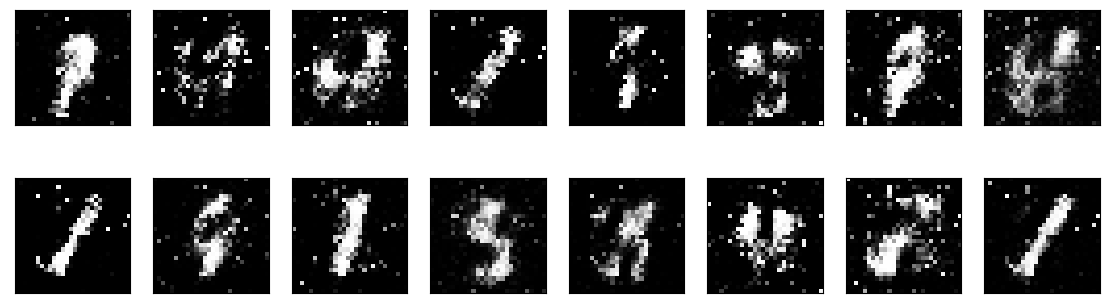

2023-07-14 15:13:47 | Epoch [35/50] | Batch 0/469 | d_loss: 0.8902 | g_loss: 2.8300
2023-07-14 15:13:50 | Epoch [35/50] | Batch 100/469 | d_loss: 0.7627 | g_loss: 2.7872
2023-07-14 15:13:53 | Epoch [35/50] | Batch 200/469 | d_loss: 0.7237 | g_loss: 2.8021
2023-07-14 15:13:56 | Epoch [35/50] | Batch 300/469 | d_loss: 0.7280 | g_loss: 2.8307
2023-07-14 15:13:58 | Epoch [35/50] | Batch 400/469 | d_loss: 0.6758 | g_loss: 2.8461


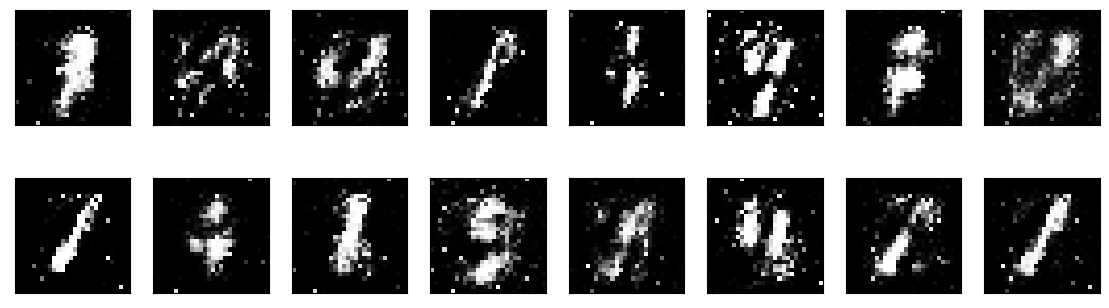

2023-07-14 15:14:08 | Epoch [36/50] | Batch 0/469 | d_loss: 0.6642 | g_loss: 2.5608
2023-07-14 15:14:10 | Epoch [36/50] | Batch 100/469 | d_loss: 0.8091 | g_loss: 2.9222
2023-07-14 15:14:14 | Epoch [36/50] | Batch 200/469 | d_loss: 0.7755 | g_loss: 3.2302
2023-07-14 15:14:16 | Epoch [36/50] | Batch 300/469 | d_loss: 0.9147 | g_loss: 2.6781
2023-07-14 15:14:19 | Epoch [36/50] | Batch 400/469 | d_loss: 0.6615 | g_loss: 2.8948


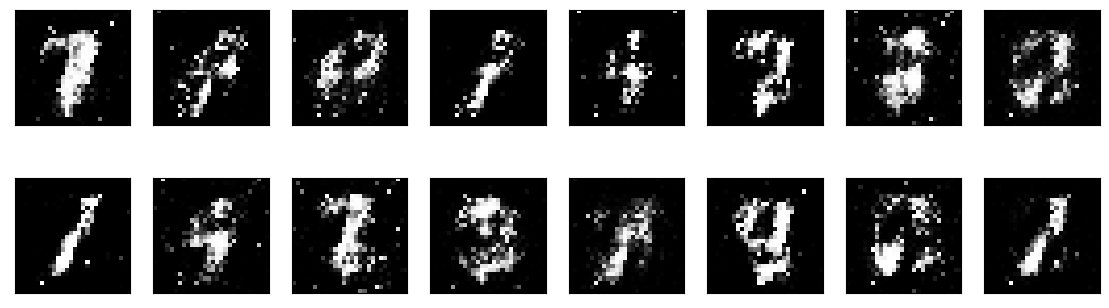

2023-07-14 15:14:28 | Epoch [37/50] | Batch 0/469 | d_loss: 0.7078 | g_loss: 3.0012
2023-07-14 15:14:30 | Epoch [37/50] | Batch 100/469 | d_loss: 0.6471 | g_loss: 3.1073
2023-07-14 15:14:33 | Epoch [37/50] | Batch 200/469 | d_loss: 0.6104 | g_loss: 3.0886
2023-07-14 15:14:36 | Epoch [37/50] | Batch 300/469 | d_loss: 0.8445 | g_loss: 2.5938
2023-07-14 15:14:39 | Epoch [37/50] | Batch 400/469 | d_loss: 0.7047 | g_loss: 3.0834


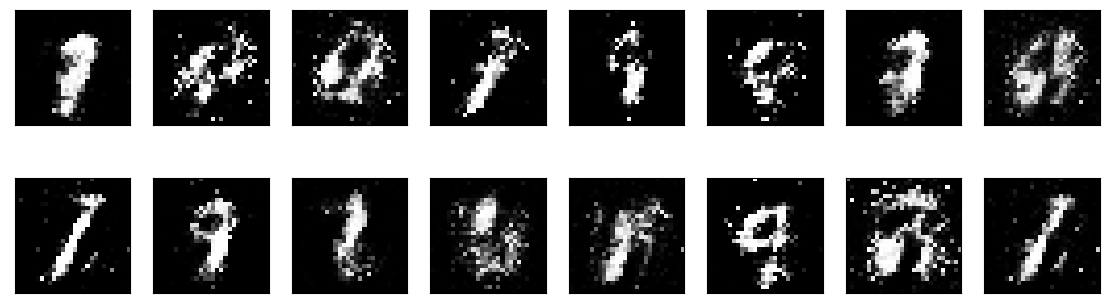

2023-07-14 15:15:00 | Epoch [38/50] | Batch 0/469 | d_loss: 0.7506 | g_loss: 3.0480
2023-07-14 15:15:03 | Epoch [38/50] | Batch 100/469 | d_loss: 0.7371 | g_loss: 2.7300
2023-07-14 15:15:06 | Epoch [38/50] | Batch 200/469 | d_loss: 0.6886 | g_loss: 2.8589
2023-07-14 15:15:08 | Epoch [38/50] | Batch 300/469 | d_loss: 0.8625 | g_loss: 2.4459
2023-07-14 15:15:11 | Epoch [38/50] | Batch 400/469 | d_loss: 0.8596 | g_loss: 2.8043


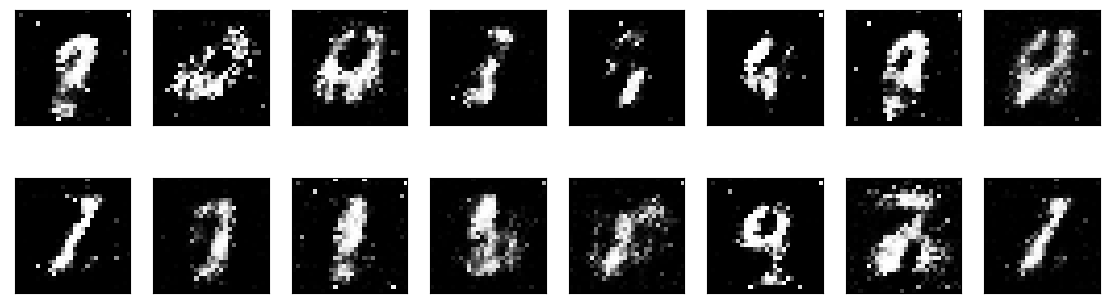

2023-07-14 15:15:20 | Epoch [39/50] | Batch 0/469 | d_loss: 0.7446 | g_loss: 3.0468
2023-07-14 15:15:22 | Epoch [39/50] | Batch 100/469 | d_loss: 0.8729 | g_loss: 2.8800
2023-07-14 15:15:25 | Epoch [39/50] | Batch 200/469 | d_loss: 0.7255 | g_loss: 3.0172
2023-07-14 15:15:27 | Epoch [39/50] | Batch 300/469 | d_loss: 0.8421 | g_loss: 2.7893
2023-07-14 15:15:30 | Epoch [39/50] | Batch 400/469 | d_loss: 0.8191 | g_loss: 2.6820


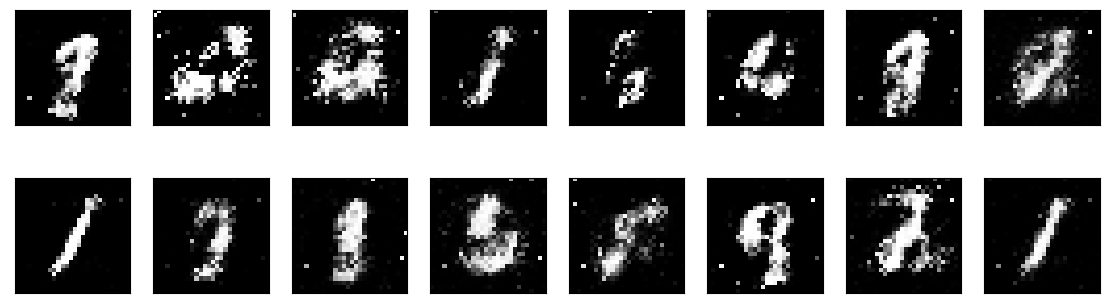

2023-07-14 15:15:38 | Epoch [40/50] | Batch 0/469 | d_loss: 0.8029 | g_loss: 2.4299
2023-07-14 15:15:41 | Epoch [40/50] | Batch 100/469 | d_loss: 0.7523 | g_loss: 2.8915
2023-07-14 15:15:44 | Epoch [40/50] | Batch 200/469 | d_loss: 0.6772 | g_loss: 2.8803
2023-07-14 15:15:46 | Epoch [40/50] | Batch 300/469 | d_loss: 0.8476 | g_loss: 2.3090
2023-07-14 15:15:49 | Epoch [40/50] | Batch 400/469 | d_loss: 0.8683 | g_loss: 2.3340


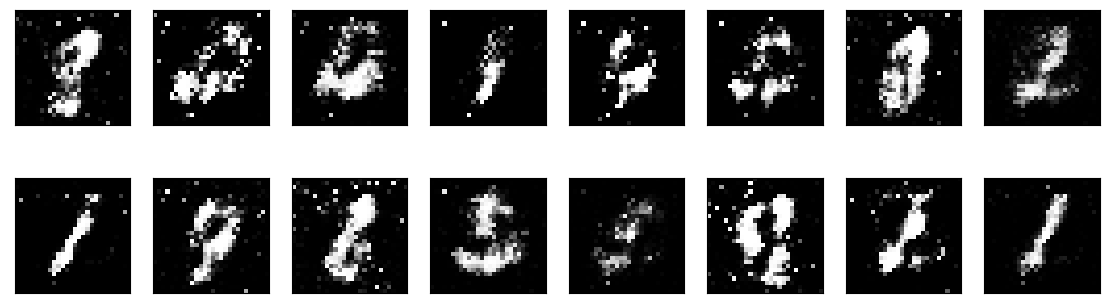

2023-07-14 15:15:59 | Epoch [41/50] | Batch 0/469 | d_loss: 0.9770 | g_loss: 1.6752
2023-07-14 15:16:02 | Epoch [41/50] | Batch 100/469 | d_loss: 0.8156 | g_loss: 2.4754
2023-07-14 15:16:05 | Epoch [41/50] | Batch 200/469 | d_loss: 0.7915 | g_loss: 2.5564
2023-07-14 15:16:07 | Epoch [41/50] | Batch 300/469 | d_loss: 0.9097 | g_loss: 2.7921
2023-07-14 15:16:11 | Epoch [41/50] | Batch 400/469 | d_loss: 0.8567 | g_loss: 2.4822


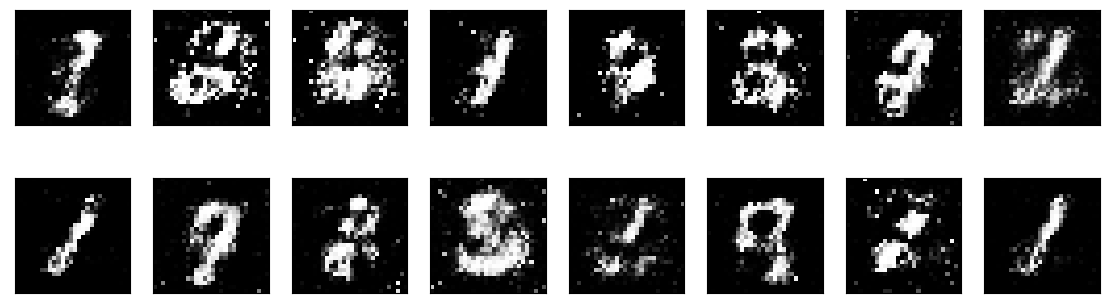

2023-07-14 15:16:20 | Epoch [42/50] | Batch 0/469 | d_loss: 0.8889 | g_loss: 2.3744
2023-07-14 15:16:23 | Epoch [42/50] | Batch 100/469 | d_loss: 0.8481 | g_loss: 2.3664
2023-07-14 15:16:25 | Epoch [42/50] | Batch 200/469 | d_loss: 0.7518 | g_loss: 2.1946
2023-07-14 15:16:28 | Epoch [42/50] | Batch 300/469 | d_loss: 0.8765 | g_loss: 2.5218
2023-07-14 15:16:30 | Epoch [42/50] | Batch 400/469 | d_loss: 0.8584 | g_loss: 2.3311


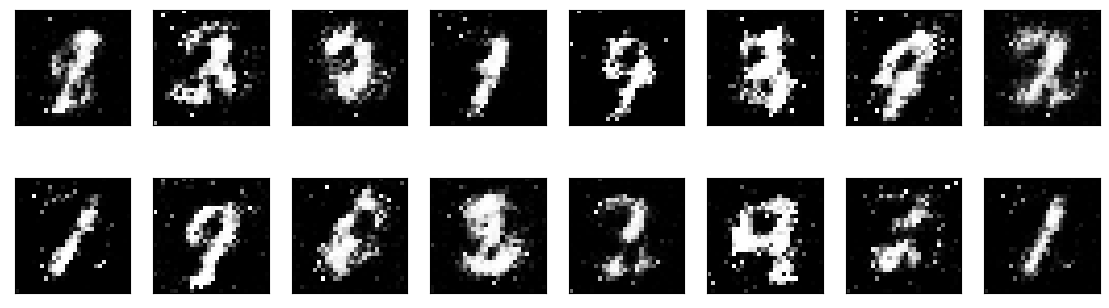

2023-07-14 15:16:40 | Epoch [43/50] | Batch 0/469 | d_loss: 0.8187 | g_loss: 2.4993
2023-07-14 15:16:42 | Epoch [43/50] | Batch 100/469 | d_loss: 0.8450 | g_loss: 2.5136
2023-07-14 15:16:46 | Epoch [43/50] | Batch 200/469 | d_loss: 0.8334 | g_loss: 2.1593
2023-07-14 15:16:48 | Epoch [43/50] | Batch 300/469 | d_loss: 0.8910 | g_loss: 2.1930
2023-07-14 15:16:51 | Epoch [43/50] | Batch 400/469 | d_loss: 0.8088 | g_loss: 2.2055


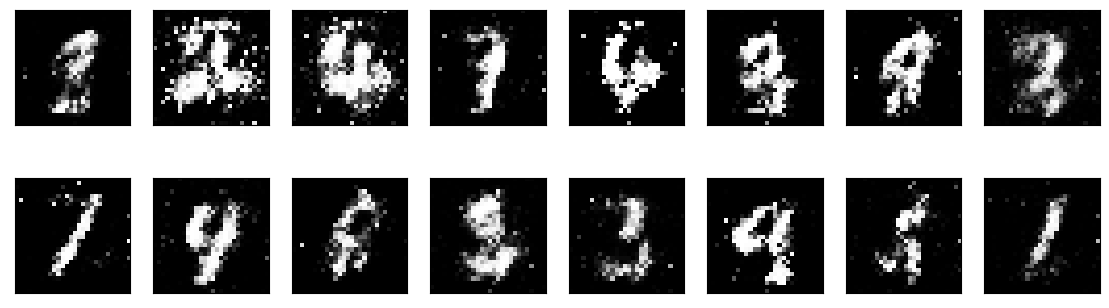

2023-07-14 15:17:00 | Epoch [44/50] | Batch 0/469 | d_loss: 0.8745 | g_loss: 2.4220
2023-07-14 15:17:03 | Epoch [44/50] | Batch 100/469 | d_loss: 0.9214 | g_loss: 2.2984
2023-07-14 15:17:06 | Epoch [44/50] | Batch 200/469 | d_loss: 0.8839 | g_loss: 2.1572
2023-07-14 15:17:09 | Epoch [44/50] | Batch 300/469 | d_loss: 0.9752 | g_loss: 2.0486
2023-07-14 15:17:12 | Epoch [44/50] | Batch 400/469 | d_loss: 0.8443 | g_loss: 2.0172


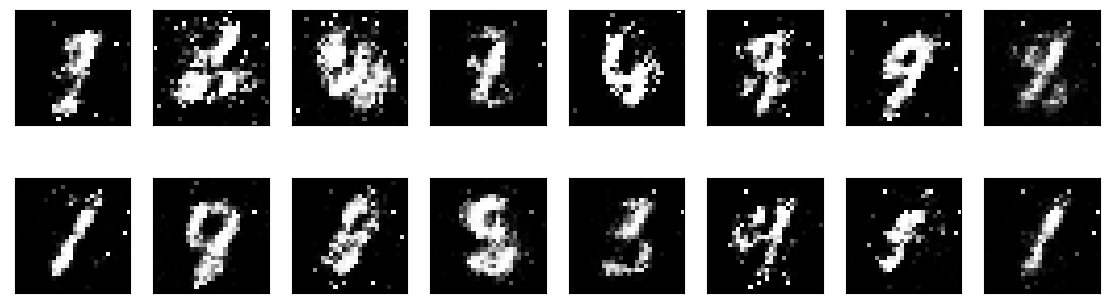

2023-07-14 15:17:21 | Epoch [45/50] | Batch 0/469 | d_loss: 0.8624 | g_loss: 2.6949
2023-07-14 15:17:23 | Epoch [45/50] | Batch 100/469 | d_loss: 0.8253 | g_loss: 2.0501
2023-07-14 15:17:26 | Epoch [45/50] | Batch 200/469 | d_loss: 0.7766 | g_loss: 2.1624
2023-07-14 15:17:31 | Epoch [45/50] | Batch 300/469 | d_loss: 0.9150 | g_loss: 2.0708
2023-07-14 15:17:37 | Epoch [45/50] | Batch 400/469 | d_loss: 0.8024 | g_loss: 2.3832


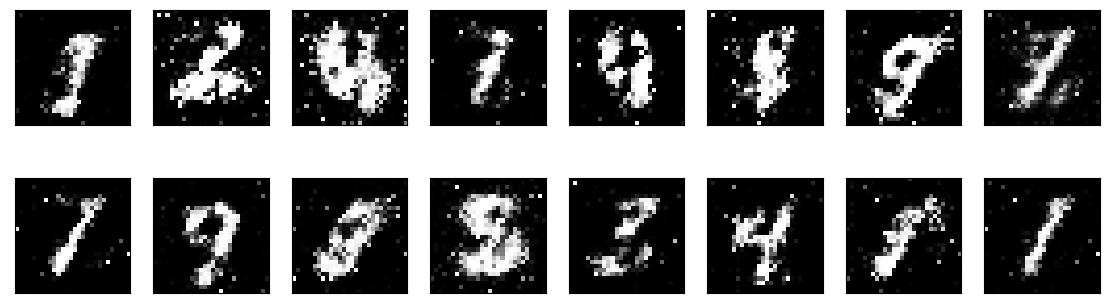

2023-07-14 15:17:54 | Epoch [46/50] | Batch 0/469 | d_loss: 0.8617 | g_loss: 2.4427
2023-07-14 15:17:57 | Epoch [46/50] | Batch 100/469 | d_loss: 0.7592 | g_loss: 2.0239
2023-07-14 15:18:00 | Epoch [46/50] | Batch 200/469 | d_loss: 0.8256 | g_loss: 2.7024
2023-07-14 15:18:03 | Epoch [46/50] | Batch 300/469 | d_loss: 0.9844 | g_loss: 2.3813
2023-07-14 15:18:06 | Epoch [46/50] | Batch 400/469 | d_loss: 0.7399 | g_loss: 2.7412


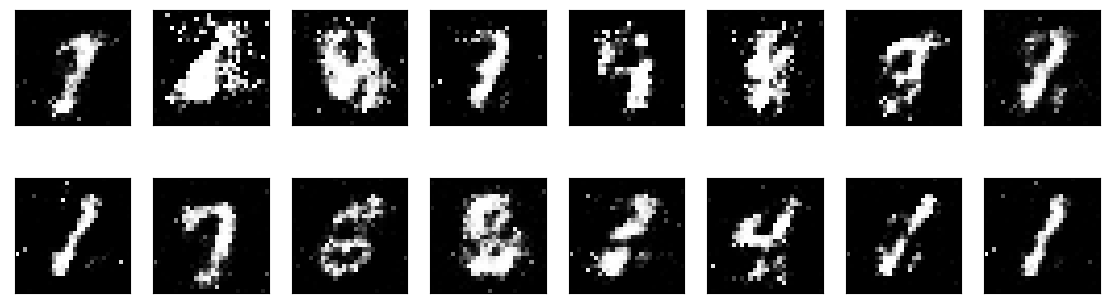

2023-07-14 15:18:15 | Epoch [47/50] | Batch 0/469 | d_loss: 0.9347 | g_loss: 2.2562
2023-07-14 15:18:17 | Epoch [47/50] | Batch 100/469 | d_loss: 0.8628 | g_loss: 2.2234
2023-07-14 15:18:20 | Epoch [47/50] | Batch 200/469 | d_loss: 0.8035 | g_loss: 2.1792
2023-07-14 15:18:23 | Epoch [47/50] | Batch 300/469 | d_loss: 0.8762 | g_loss: 2.1262
2023-07-14 15:18:25 | Epoch [47/50] | Batch 400/469 | d_loss: 0.8569 | g_loss: 2.1079


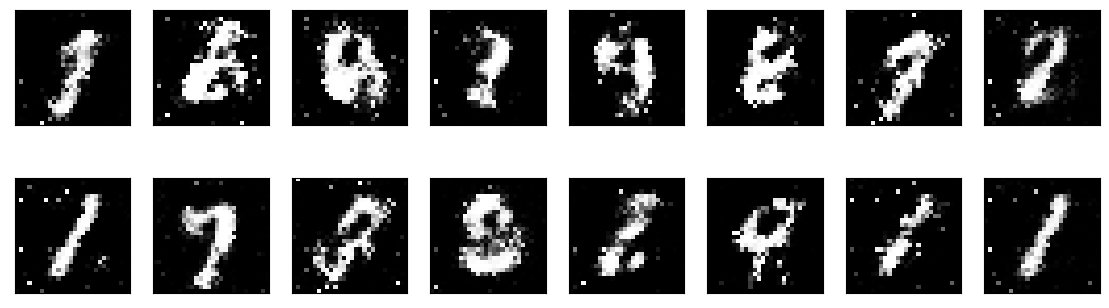

2023-07-14 15:18:34 | Epoch [48/50] | Batch 0/469 | d_loss: 1.0267 | g_loss: 1.7548
2023-07-14 15:18:36 | Epoch [48/50] | Batch 100/469 | d_loss: 0.9006 | g_loss: 2.0340
2023-07-14 15:18:39 | Epoch [48/50] | Batch 200/469 | d_loss: 0.8847 | g_loss: 1.9883
2023-07-14 15:18:41 | Epoch [48/50] | Batch 300/469 | d_loss: 0.8396 | g_loss: 1.9845
2023-07-14 15:18:44 | Epoch [48/50] | Batch 400/469 | d_loss: 0.9157 | g_loss: 2.1757


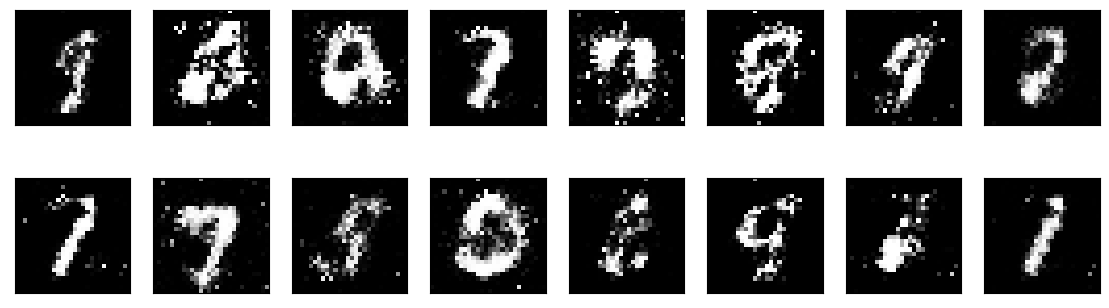

2023-07-14 15:18:53 | Epoch [49/50] | Batch 0/469 | d_loss: 0.8387 | g_loss: 2.0184
2023-07-14 15:18:55 | Epoch [49/50] | Batch 100/469 | d_loss: 0.8812 | g_loss: 2.2309
2023-07-14 15:18:58 | Epoch [49/50] | Batch 200/469 | d_loss: 0.8914 | g_loss: 2.2318
2023-07-14 15:19:00 | Epoch [49/50] | Batch 300/469 | d_loss: 0.9921 | g_loss: 2.3811
2023-07-14 15:19:03 | Epoch [49/50] | Batch 400/469 | d_loss: 0.9846 | g_loss: 2.1991


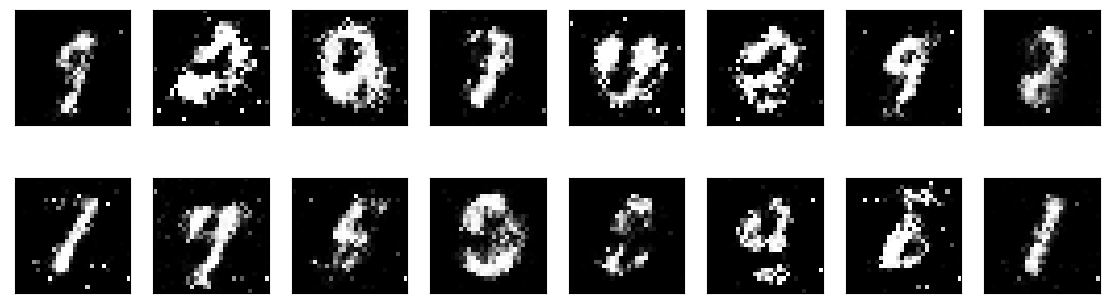

2023-07-14 15:19:11 | Epoch [50/50] | Batch 0/469 | d_loss: 0.8858 | g_loss: 1.8967
2023-07-14 15:19:14 | Epoch [50/50] | Batch 100/469 | d_loss: 0.9730 | g_loss: 2.0533
2023-07-14 15:19:17 | Epoch [50/50] | Batch 200/469 | d_loss: 0.7706 | g_loss: 2.0060
2023-07-14 15:19:19 | Epoch [50/50] | Batch 300/469 | d_loss: 0.9527 | g_loss: 2.0703
2023-07-14 15:19:22 | Epoch [50/50] | Batch 400/469 | d_loss: 0.8820 | g_loss: 2.0798


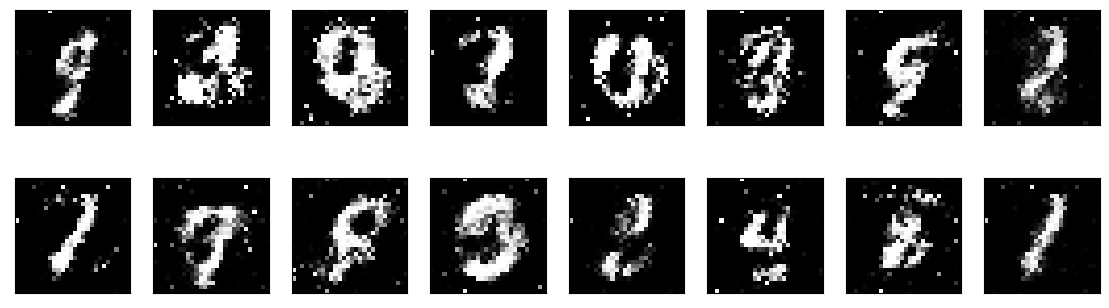

In [14]:


# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = get_random_latent_batch(sample_size, z_size)

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        ####
        # IMPLEMENT HERE
        ####
        d_optimizer.zero_grad()
        
        # 1. Compute the discriminator loss on real, training images
        d_real_out = D(real_images)
        d_real_loss = real_loss(d_real_out, True)
        
        # 2. Generate random fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = get_random_latent_batch(batch_size, z_size)
            fake_imgs = G(z)
        
        # 3. Compute the discriminator loss on fake, generated images
        d_fake_out = D(fake_imgs)
        d_fake_loss = fake_loss(d_fake_out)
        
        # 4. Add up real and fake loss
        d_loss = d_real_loss + d_fake_loss
        
        # 5. Perform backpropagation + an optimization step to update the discriminator's weights
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        ####
        # IMPLEMENT HERE
        ####
        g_optimizer.zero_grad()
        
        # 1. Generate random fake images        
        z = get_random_latent_batch(batch_size, z_size)
        fake_imgs = G(z)

        
        # 2. Compute the discriminator loss on fake images, using flipped labels!
        g_loss = real_loss(D(fake_imgs)) # real loss to flip label
        
        # 3. Perform backpropagation + an optimization step to update the generator's weights
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
            ## AFTER EACH EPOCH##
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

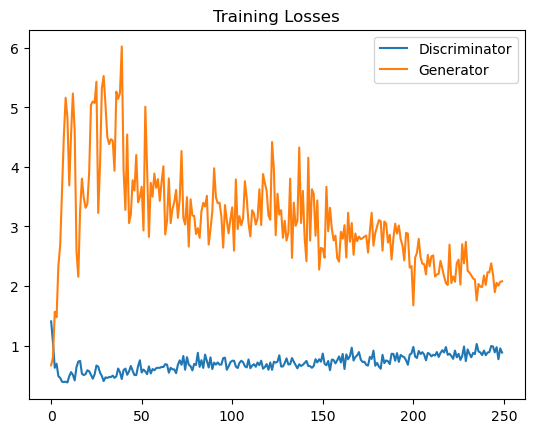

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [16]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

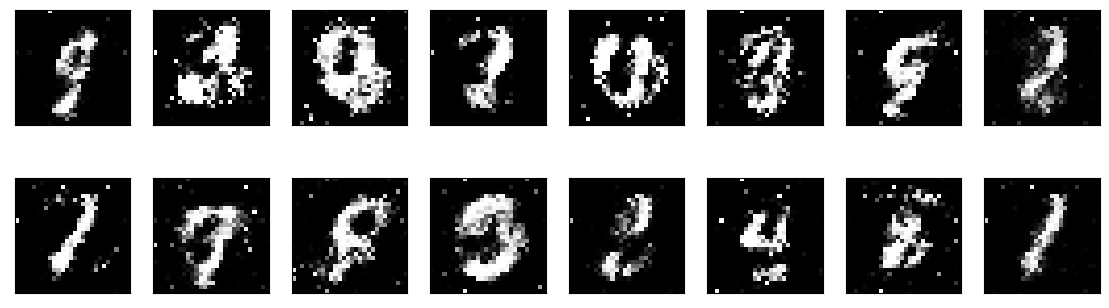

In [17]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

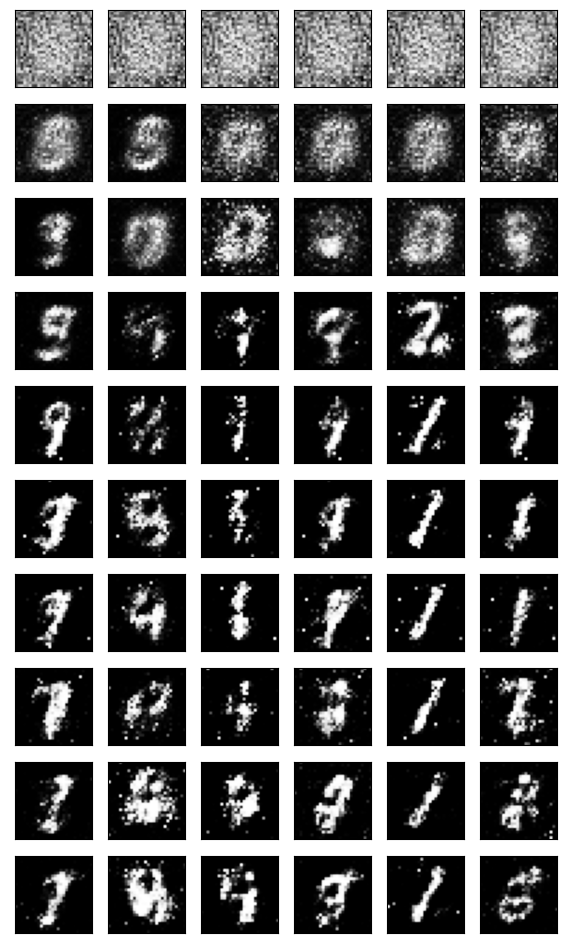

In [18]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

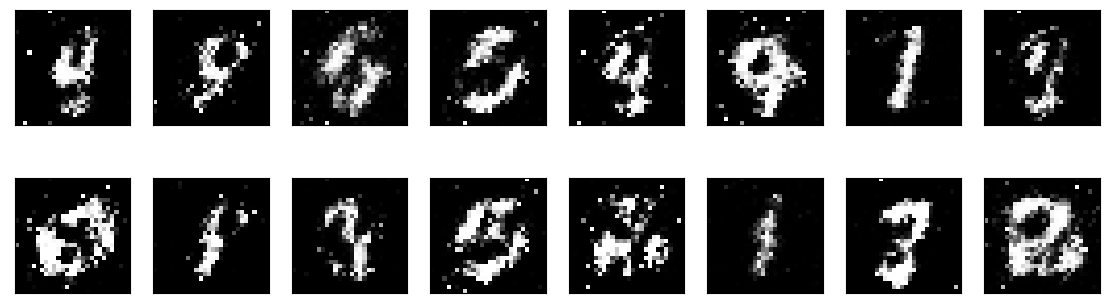

In [19]:
# randomly generated, new latent vectors
sample_size = 16
rand_z = get_random_latent_batch(sample_size, z_size)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

In [20]:
print('done!')

done!
